# Parameterizing best Network

In [12]:
classes = [
			"airplane",
			"automobile",
			"bird",
			"cat",
			"deer",
			"dog",
			"frog",
			"horse",
			"ship",
			"truck"
		]

## Import necessary packages

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim

## Loading the testset

In [14]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(),
								transforms.Normalize((0.4919, 0.4827, 0.4472),
														(0.2022, 0.1994, 0.2010)),
								])

testset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified


## Loading the best network

In [15]:
class Network(nn.Module):
	def __init__(self):
		super().__init__()

		self.fc1 = nn.Linear(3072, 1024)
		self.fc2 = nn.Linear(1024, 512)
		self.fc3 = nn.Linear(512, 256)
		self.fc4 = nn.Linear(256, 10)

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = x.view(x.shape[0], -1)

		x = self.dropout(F.relu(self.fc1(x)))
		x = self.dropout(F.relu(self.fc2(x)))
		x = self.dropout(F.relu(self.fc3(x)))

		x = F.log_softmax(self.fc4(x), dim=1)

		return x

In [16]:
state_dict = torch.load("checkpoint.pth")
network = Network()

network.load_state_dict(state_dict)

C:\Users\bran-\AppData\Local\Temp\ipykernel_16312\2667621187.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("checkpoint.pth")


<All keys matched successfully>

## Analysis

In [17]:
network.eval()

all_preds = []
all_labels = []

with torch.no_grad():
	for images, labels in testloader:
		log_ps = network(images)
		ps = torch.exp(log_ps)
		top_p, top_class = ps.topk(1, dim=1)
		all_preds.extend(top_class.squeeze().numpy())
		all_labels.extend(labels.numpy())

### Confusion matrix

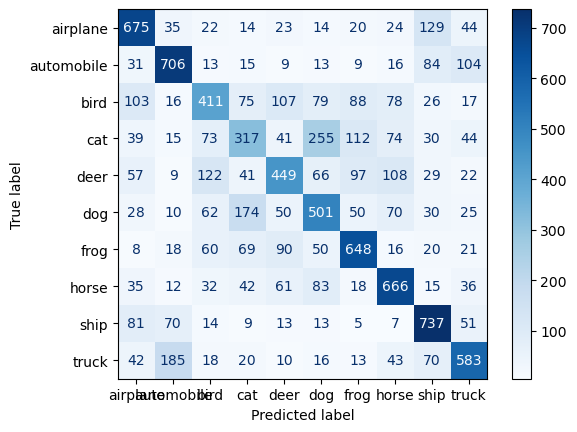

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Analysis by class

#### Precision

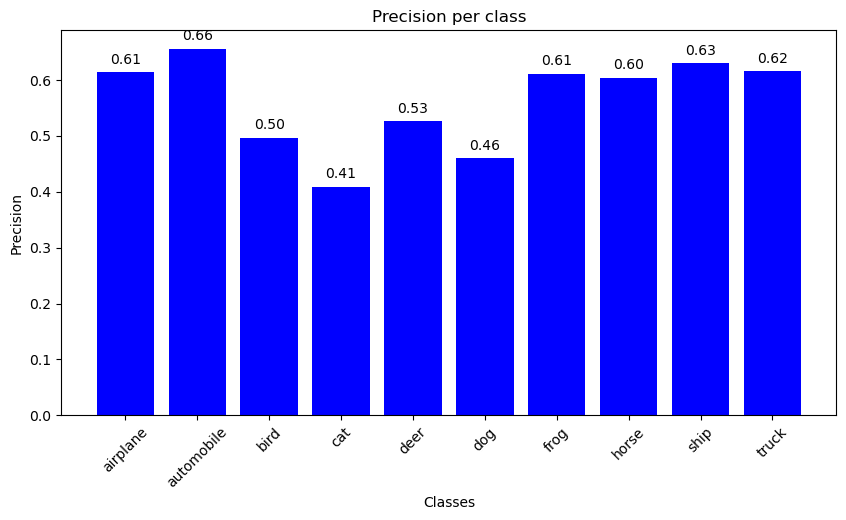

In [19]:
from sklearn.metrics import precision_score


precision_per_class = precision_score(all_labels, all_preds, average=None)
plt.figure(figsize=(10, 5))
plt.bar(classes, precision_per_class, color="blue")
plt.xlabel("Classes")
plt.ylabel("Precision")
plt.title("Precision per class")
plt.xticks(rotation=45)
for i, v in enumerate(precision_per_class):
	plt.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom")
plt.show()

### Recall

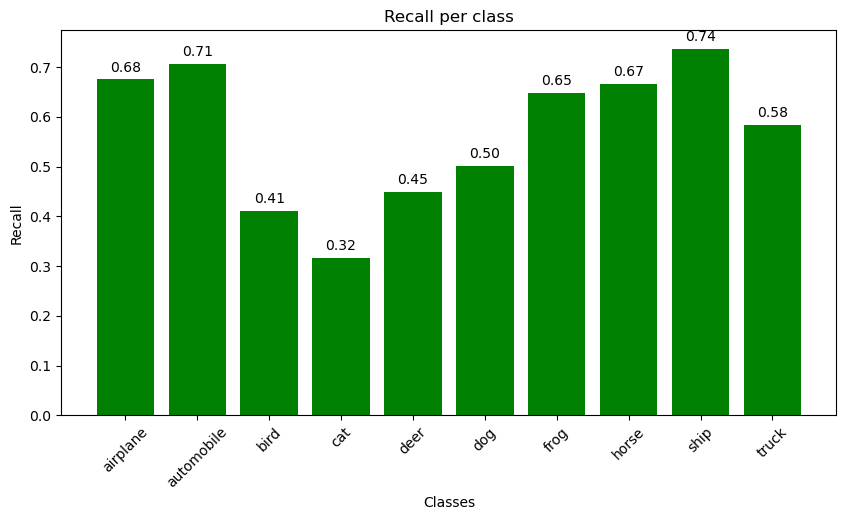

In [20]:
from sklearn.metrics import recall_score

recall_per_class = recall_score(all_labels, all_preds, average=None)
plt.figure(figsize=(10, 5))
plt.bar(classes, recall_per_class, color="green")
plt.xlabel("Classes")
plt.ylabel("Recall")
plt.title("Recall per class")
plt.xticks(rotation=45)
for i, v in enumerate(recall_per_class):
	plt.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom")
plt.show()

#### F1 score

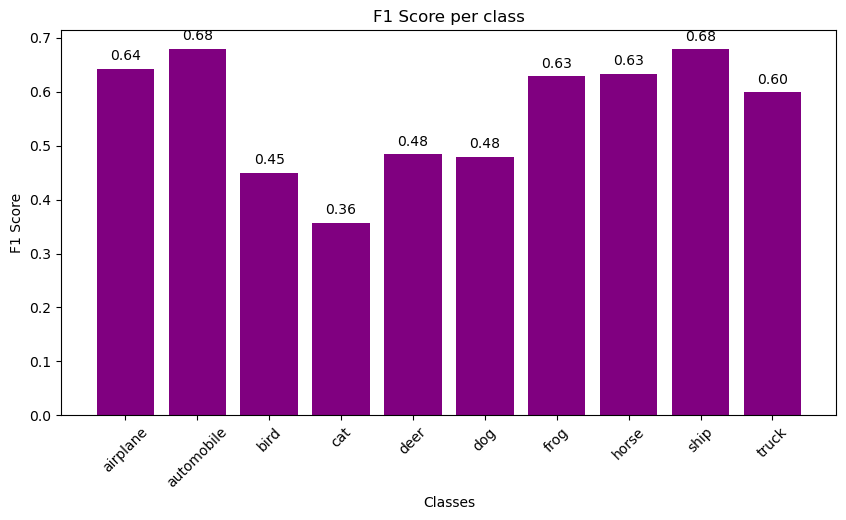

In [21]:
from sklearn.metrics import f1_score

f1_per_class = f1_score(all_labels, all_preds, average=None)
plt.figure(figsize=(10, 5))
plt.bar(classes, f1_per_class, color="purple")
plt.xlabel("Classes")
plt.ylabel("F1 Score")
plt.title("F1 Score per class")
plt.xticks(rotation=45)
for i, v in enumerate(f1_per_class):
	plt.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom")
plt.show()

#### ROC and AUC

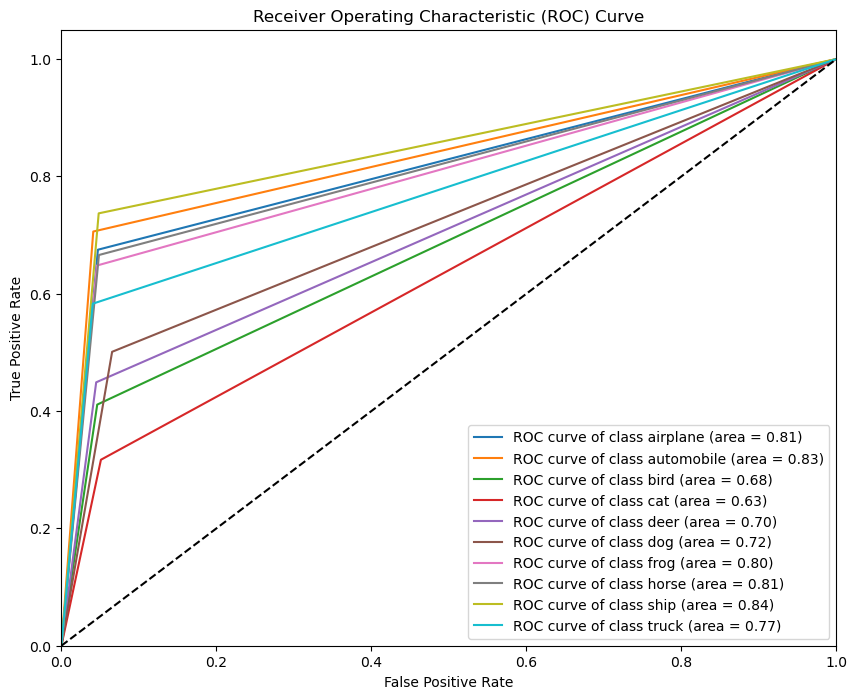

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


# Binarize the labels for multi-class ROC
all_labels_binarized = label_binarize(all_labels, classes=range(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
	fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], np.array(all_preds) == i)
	roc_auc[i] = roc_auc_score(all_labels_binarized[:, i], np.array(all_preds) == i)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
	plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()